# Batch Normalization

## 1. What is Batch Normalization?

Batch Norm is created by two researchers, Sergey Ioffe and Christian Szegedy.

For original Normalization, it can turn the contours of learning problem from something that might be very elongated to something that is more round, and it is easier for an algorithm like gradient descent to optimize.

what batch norm does is it applies that normalization process not just to the input layer, but to the values even deep in some hidden layer in the neural network. So it will apply this type of normalization to normalize the mean and variance of some of your hidden units' values, 

Algorithm:

Given the intermediate values in NN，$Z^{1}$,$Z^{2}$,$Z^{3}$,...,$Z^{m}$

$ \mu = \frac{1}{m}\sum_{i} Z^{(i)}$

$\sigma^{2} = \frac{1}{m} \sum_{i} (Z^{(i)}-\mu)^{2}$

$Z_{norm}^{(i)} = \frac{Z^{(i)}-\mu}{\sqrt{\sigma^{2}+\epsilon}}$

$\widetilde{Z}^{(i)} = \gamma Z_{norm}^{(i)} + \beta $

But one difference between the training input and these hidden unit values is you might not want your hidden unit values be forced to have mean 0 and variance 1.

what Batch Norm really does is that it normalizes in mean and variance of these hidden unit values, to have some fixed mean and variance. And that mean and variance could be 0 and 1, or it could be some other value, and it's controlled by these parameters gamma and beta.

In the BN2015 paper, Ioffe and Szegedy show that batch normalization enables the use of higher learning rates, acts as a regularizer and can speed up training by 14 times.

## 2. Implement Batch Normalization in Tensorflow

We will add batch normalization to a basic fully-connected neural network that has two hidden layers of 100 neurons each and show a similar result to Figure 1 (b) and (c) of the BN2015 paper.

Note that this network is not yet generally suitable for use at test time. See the section Making predictions with the model below for the reason why.

### Imports, config

In [2]:
import numpy as np, tensorflow as tf
import tqdm
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# Generate predetermined random weights so the networks are similarly initialized
w1_initial = np.random.normal(size=(784,100)).astype(np.float32)
w2_initial = np.random.normal(size=(100,100)).astype(np.float32)
w3_initial = np.random.normal(size=(100,10)).astype(np.float32)

# Small epsilon value for the BN transform
epsilon = 1e-3

### Building the graph


In [5]:
# Placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [6]:
# Layer 1 without BN
w1 = tf.Variable(w1_initial)
b1 = tf.Variable(tf.zeros([100]))
z1 = tf.matmul(x,w1)+b1
l1 = tf.nn.sigmoid(z1)

Here is the same layer 1 with batch normalization:

In [7]:
# Layer 1 with BN
w1_BN = tf.Variable(w1_initial)

# Note that pre-batch normalization bias is ommitted. The effect of this bias would be
# eliminated when subtracting the batch mean. Instead, the role of the bias is performed
# by the new beta variable. See Section 3.2 of the BN2015 paper.
z1_BN = tf.matmul(x,w1_BN)

# Calculate batch mean and variance
batch_mean1, batch_var1 = tf.nn.moments(z1_BN,[0])

# Apply the initial batch normalizing transform
z1_hat = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)

# Create two new parameters, scale and beta (shift)
scale1 = tf.Variable(tf.ones([100]))
beta1 = tf.Variable(tf.zeros([100]))

# Scale and shift to obtain the final output of the batch normalization
# this value is fed into the activation function (here a sigmoid)
BN1 = scale1 * z1_hat + beta1
l1_BN = tf.nn.sigmoid(BN1)

In [11]:
# Layer 2 without BN
w2 = tf.Variable(w2_initial)
b2 = tf.Variable(tf.zeros([100]))
z2 = tf.matmul(l1,w2)+b2
l2 = tf.nn.sigmoid(z2)

Note that tensorflow provides a `tf.nn.batch_normalization`, which I apply to layer 2 below. This code does the same thing as the code for layer 1 above. 

In [12]:
# Layer 2 with BN, using Tensorflows built-in BN function
w2_BN = tf.Variable(w2_initial)
z2_BN = tf.matmul(l1_BN,w2_BN)
batch_mean2, batch_var2 = tf.nn.moments(z2_BN,[0])
scale2 = tf.Variable(tf.ones([100]))
beta2 = tf.Variable(tf.zeros([100]))
BN2 = tf.nn.batch_normalization(z2_BN,batch_mean2,batch_var2,beta2,scale2,epsilon)
l2_BN = tf.nn.sigmoid(BN2)

In [13]:
# Softmax
w3 = tf.Variable(w3_initial)
b3 = tf.Variable(tf.zeros([10]))
y  = tf.nn.softmax(tf.matmul(l2,w3)+b3)

w3_BN = tf.Variable(w3_initial)
b3_BN = tf.Variable(tf.zeros([10]))
y_BN  = tf.nn.softmax(tf.matmul(l2_BN,w3_BN)+b3_BN)

In [14]:
# Loss, optimizer and predictions
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
cross_entropy_BN = -tf.reduce_sum(y_*tf.log(y_BN))

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
train_step_BN = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy_BN)

correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
correct_prediction_BN = tf.equal(tf.arg_max(y_BN,1),tf.arg_max(y_,1))
accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction_BN,tf.float32))

### Train

In [15]:
zs, BNs, acc, acc_BN = [], [], [], []

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in tqdm.tqdm(range(40000)):
    batch = mnist.train.next_batch(60)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    train_step_BN.run(feed_dict={x: batch[0], y_: batch[1]})
    if i % 50 is 0:
        res = sess.run([accuracy,accuracy_BN,z2,BN2],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        acc.append(res[0])
        acc_BN.append(res[1])
        zs.append(np.mean(res[2],axis=0)) # record the mean value of z2 over the entire test set
        BNs.append(np.mean(res[3],axis=0)) # record the mean value of BN2 over the entire test set

zs, BNs, acc, acc_BN = np.array(zs), np.array(BNs), np.array(acc), np.array(acc_BN)

100%|██████████| 40000/40000 [08:04<00:00, 82.51it/s]


### Improvements in speed and accuracy
As seen below, there is a noticeable improvement in the accuracy and speed of training. As shown in figure 2 of the BN2015 paper, this difference can be very significant for other network architectures.

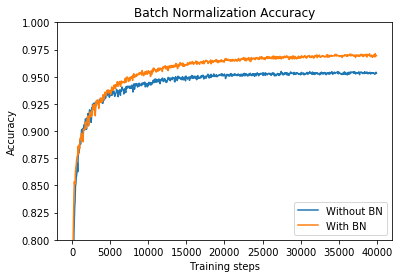

In [16]:
fig, ax = plt.subplots()

ax.plot(range(0,len(acc)*50,50),acc, label='Without BN')
ax.plot(range(0,len(acc)*50,50),acc_BN, label='With BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

### llustration of input to activation functions over time

Below is the distribution over time of the inputs to the sigmoid activation function of the first five neurons in the network’s second layer. Batch normalization has a visible and significant effect of removing variance/noise in these inputs. As described by Ioffe and Szegedy, this allows the third layer to learn faster and is responsible for the increase in accuracy and learning speed. See Figure 1 and Section 4.1 of the BN2015 paper.

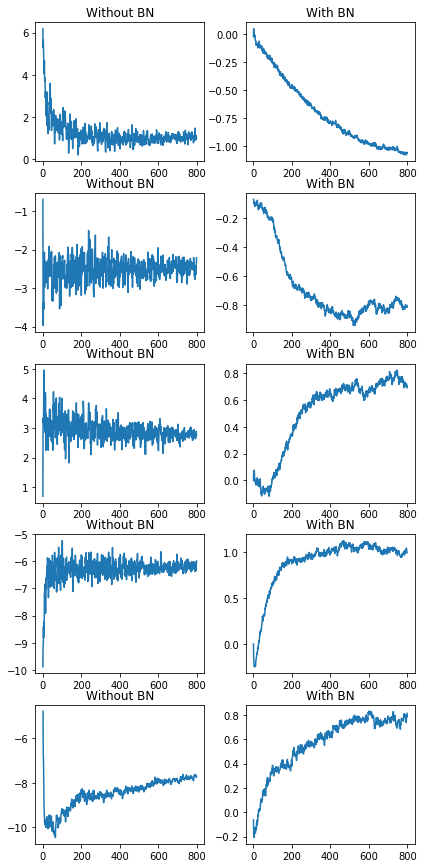

In [20]:
fig, axes = plt.subplots(5, 2, figsize=(6,12))
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title("Without BN")
    ax[1].set_title("With BN")
    ax[0].plot(zs[:,i])
    ax[1].plot(BNs[:,i])
plt.show()

## 3. Batch Normalization on Test Set

to be continued...